<h2>I am Advait gaur,  currently working on my project, named "Sign Langauge Recognition"</h2>

This is Transfer Learning on Sign Language Recognition.

Firstly, we import all neccessary modules.


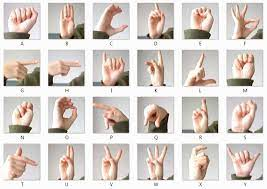

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import seaborn as sns
import pandas as pd
from torchvision.transforms import Resize, ToTensor

<h2>Training and Test Set is of size (27455, 785) where 1 columns are taken by label, so there are basically 784 pixels as illustrated below


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

pd.set_option('display.max_rows', 29)


train = pd.read_csv('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_test.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train.head(10)

mapping = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}

Mounted at /content/drive/


<h2>Shape of Image_final is (27455, 28 , 28), here 784 pixel is converted into 28x28:

In [3]:
text="pixel"
images=torch.zeros((train.shape[0],1)) #Making row tensor with all entries 0
for i in range(1,785):
    temp_text=text+str(i)
    temp=train[temp_text]
    temp=torch.FloatTensor(temp).unsqueeze(1) #Just making a row tensor with pixel<i> from csv file by putting all the values of column pixel<i>
    images=torch.cat((images,temp),1) #Here Concatenates image tensor with temp tensor along axis 1
images_final=torch.FloatTensor(images[:,1:]).view(-1,28,28) #all rows included, and column containing ,zero discarded and taken up all other columns and view in 28*28

label = train["label"]
label = torch.FloatTensor(label).unsqueeze(1)


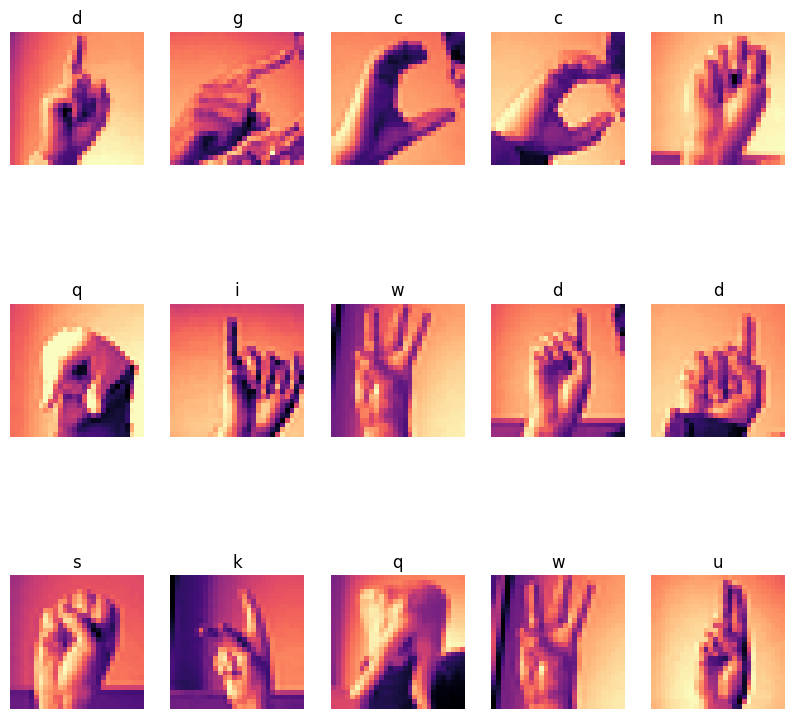

In [4]:
fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 3

for i in range(15):
    img = images_final[i, :]
    img = img.numpy()
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, cmap='magma')
    plt.title(f'{mapping[int(label[i])]}')
    plt.axis('off')

plt.show()


In [5]:
class GestureDataset(Dataset):
    def __init__(self, csv, transform=None):
        self.csv = pd.read_csv(csv)
        self.transform = transform

    def __getitem__(self, index):
        img = self.csv.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28))
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        label = self.csv.iloc[index, 0]
        return img, label

    def __len__(self):
        return len(self.csv)

In [6]:
transform = transforms.Compose([
    Resize((224, 224)),
    ToTensor(),
])

train_dataset = GestureDataset('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_train.csv', transform=transform)
val_dataset = GestureDataset('/content/drive/MyDrive/Sign Language Reco/Sign Language Reco/sign_mnist_test.csv', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

dataset_ = {"train": train_loader, "val": val_loader}


In [7]:
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs, device=device):
      training_loss=[]
      training_accuracy=[]
      val_loss=[]
      val_accuracy=[]
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      model.to(device)

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()
          else:
            model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataset_[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / len(dataset_[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataset_[phase].dataset)

          if phase=='train':
            training_loss.append(epoch_loss)
            training_accuracy.append(epoch_acc)

          elif phase=='val':
            val_loss.append(epoch_loss)
            val_accuracy.append(epoch_acc)


          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      model.load_state_dict(best_model_wts)
      return model,training_accuracy,training_loss,val_accuracy,val_loss

In [8]:
model = models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 304MB/s]


In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 26)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 0/1
----------
train Loss: 1.1514 Acc: 0.7902
val Loss: 0.3458 Acc: 0.9578

Epoch 1/1
----------
train Loss: 0.0970 Acc: 0.9991
val Loss: 0.0927 Acc: 0.9941

Training complete in 3m 46s
Best val Acc: 0.994144


In [45]:
torch.save(model_ft[0].state_dict(), 'SIGN_LANGUAGE_RECO_model.pth')


**To load the data just use the name of the model**

<h4> Create an instance of the model </h4>



```
model = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model.fc = nn.Linear(num_ftrs, 26)
```




<h4> Load the saved model </h4>


```
model.load_state_dict(torch.load('SIGN_LANGUAGE_RECO_model.pth'))
```




<h4> Set the model to evaluation mode </h4>


```
model.eval()

```


